Forecasts should outperform the following "null models":

 - Feed-forward: predicted mortality is the most recent observation in each pixel.
 - Average: predicted mortality is the mean of observed values in the pixel.

We will have to be a little creative to get these to work in the torch framework.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchmetrics
from tqdm import tqdm

import os
try:
    import util
except ImportError:
    os.chdir("..")
finally:
    import util

In [2]:
# Prepare data
# Ignore total BA calculation because we don't use those at all here.

ds = xr.open_dataset("data_working/westmort.nc")

ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

years = ds.time.values

train_years = years[16:]
valid_years = years[:8]
test_years = years[8:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004]
Testing years: [2005 2006 2007 2008 2009 2010 2011 2012]


/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


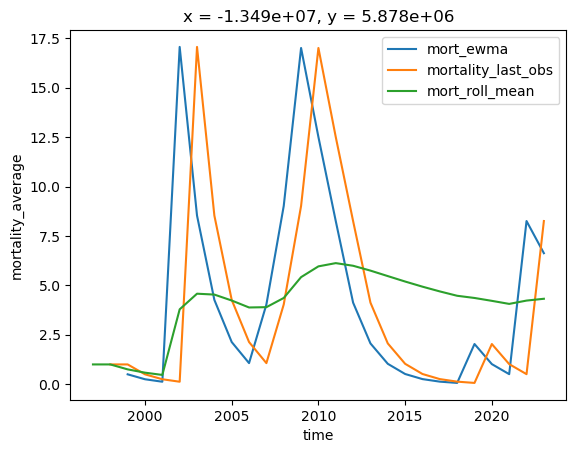

In [3]:
# Geometric mean over time of the training set
def safe_geometric_mean(arr, dim):
    # Prevent -Inf
    arr = (arr / 100) + 1e-3
    
    arr_log = np.log(arr)
    arr_log_mean = arr_log.mean(dim=dim)
    return (np.exp(arr_log_mean) - 1e-3) * 100

# Spatial average uses a rolling mean, as if we continually updated our average
# in an operational setting.
ds["mortality_average"] = np.nancumsum(ds.mort_ewma, axis=2) / np.cumsum(~np.isnan(ds.mort_ewma), axis=2)

# Last valid observation in a cell
ds["mortality_last_obs"] = ds.mort_ewma.ffill(dim="time").shift(time=1)

fig, ax = plt.subplots()

ds.isel(x=100, y=100).mort_ewma.plot(ax=ax, label="mort_ewma")
ds.isel(x=100, y=100).mortality_last_obs.plot(ax=ax, label="mortality_last_obs")
ds.isel(x=100, y=100).mortality_average.plot(ax=ax, label="mort_roll_mean")

ax.legend()
plt.show()

In [4]:
# Use the same setup as when we train the convnets
window = dict(x=[16, False], y=[16, False], time=[5, False])
prop_na = 0.8
valid_wds = util.datasets.WindowXarrayDataset(ds.sel(time=valid_years), window, mask="mort_ewma", na_thresh=prop_na)
test_wds  = util.datasets.WindowXarrayDataset(ds.sel(time=test_years), window, mask="mort_ewma", na_thresh=prop_na)

print("N valid", len(valid_wds))
print("N test", len(test_wds))

N valid 38421
N test 83017


In [5]:
# Windows have the "null models" already associated so we can just iterate
# over and calculate metrics.
w = valid_wds[10]
w

<xarray.Dataset> Size: 103kB
Dimensions:             (time: 5, x: 16, y: 16)
Coordinates:
  * time                (time) int64 40B 1999 2000 2001 2002 2003
  * x                   (x) float64 128B -1.347e+07 -1.347e+07 ... -1.341e+07
  * y                   (y) float64 128B 6.278e+06 6.274e+06 ... 6.218e+06
Data variables: (12/20)
    abies               (time, y, x) float32 5kB ...
    picea               (time, y, x) float32 5kB ...
    populus             (time, y, x) float32 5kB ...
    pseudotsuga         (time, y, x) float32 5kB ...
    tsuga               (time, y, x) float32 5kB ...
    vod                 (time, y, x) float32 5kB ...
    ...                  ...
    tmin                (time, y, x) float32 5kB ...
    treecover           (time, y, x) float32 5kB ...
    spatial_ref         int64 8B ...
    mort_ewma           (y, x, time) float32 5kB nan nan nan ... 1.0 0.5 1.25
    mortality_average   (y, x, time) float64 10kB nan nan nan ... 0.375 0.55
    mortality_last_obs  (y, x, time) float32 5kB nan nan nan nan ... 0.0 1.0 0.5

In [12]:
last_obs_valid_metrics = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
last_obs_test_metrics  = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
avg_valid_metrics = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]
avg_test_metrics  = util.training.get_regr_metrics() + [torchmetrics.MeanSquaredError()]

for patch in tqdm(valid_wds):
    target   = torch.tensor(patch.mort_ewma.isel(time=-1).values)
    last_obs = torch.tensor(patch.mortality_last_obs.isel(time=-1).values)
    avg      = torch.tensor(patch.mortality_average.isel(time=-1).values)
    # fix nans
    avg = torch.nan_to_num(avg)
    last_obs = torch.nan_to_num(last_obs)

    mask = ~torch.isnan(target.view(-1))
    m_target   = target.view(-1)[mask]
    m_last_obs = last_obs.view(-1)[mask]
    m_avg      = avg.view(-1)[mask]
    
    for m in last_obs_valid_metrics:
        m(m_last_obs, m_target)

    for m in avg_valid_metrics:
        m(m_avg, m_target)

for patch in tqdm(test_wds):
    target   = torch.tensor(patch.mort_ewma.isel(time=-1).values)
    last_obs = torch.tensor(patch.mortality_last_obs.isel(time=-1).values)
    avg      = torch.tensor(patch.mortality_average.isel(time=-1).values)
    # fix nans
    avg = torch.nan_to_num(avg)
    last_obs = torch.nan_to_num(last_obs)

    mask = ~torch.isnan(target.view(-1))
    m_target   = target.view(-1)[mask]
    m_last_obs = last_obs.view(-1)[mask]
    m_avg      = avg.view(-1)[mask]
    
    for m in last_obs_test_metrics:
        m(m_last_obs, m_target)

    for m in avg_test_metrics:
        m(m_avg, m_target)


100%|██████████| 83017/83017 [07:32<00:00, 183.53it/s]


In [13]:
print("Last observation, validation")
for metric in last_obs_valid_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Last observation, testing")
for metric in last_obs_test_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Time average, validation")
for metric in avg_valid_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

print("Time average, testing")
for metric in avg_test_metrics:
    print(f"\t{str(metric)}: {metric.compute():.3f}")

Last observation, validation
	NormalizedRootMeanSquaredError(): 2.194
	PearsonCorrCoef(): 0.684
	MeanAbsoluteError(): 1.454
	MeanSquaredError(): 22.755
	MeanSquaredError(): 22.755
Last observation, testing
	NormalizedRootMeanSquaredError(): 1.831
	PearsonCorrCoef(): 0.831
	MeanAbsoluteError(): 0.818
	MeanSquaredError(): 6.018
	MeanSquaredError(): 6.018
Time average, validation
	NormalizedRootMeanSquaredError(): 2.139
	PearsonCorrCoef(): 0.799
	MeanAbsoluteError(): 1.429
	MeanSquaredError(): 21.632
	MeanSquaredError(): 21.632
Time average, testing
	NormalizedRootMeanSquaredError(): 2.352
	PearsonCorrCoef(): 0.644
	MeanAbsoluteError(): 1.214
	MeanSquaredError(): 9.921
	MeanSquaredError(): 9.921


When interpreting these remember that we didn't divide through by 100, so the MAE and MSE values should be interpreted as percentages.